# Task 1: Language model inference

The goal if this first task is to familiarize yourself with the huggingface transformers and dataset libraries. You will learn how to load and tokenize a dataset, how to load a pre-trained language model, and finally, how to run a model in inference mode.

Your task is to complete the missing code blocks below.

In [1]:
packages_to_install = ["ipywidgets", "numpy=1.24.0", "torch", "matplotlib", "sentencepiece", "protobuf", "datasets", "transformers", "diffusers", "peft", "h5py", "scikit-learn", "scipy", "wandb"]

In [2]:
!conda config --add channels conda-forge

In [3]:
%%time
import importlib

for package_name in packages_to_install:
    try:
        importlib.import_module(package_name)
        print(f"{package_name} is already installed.")
    except ImportError:
        print(f"{package_name} is not installed. Installing it now...")
        !conda install -y {package_name}

ipywidgets is already installed.
numpy=1.24.0 is not installed. Installing it now...
Retrieving notices: ...working... done
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.1.2



# All requested packages already installed.

torch is already installed.
matplotlib is already installed.
sentencepiece is already installed.
protobuf is not installed. Installing it now...
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.1.2



# All requested packages already installed

In [46]:
# import dependencies
import matplotlib.pyplot as plt
import numpy as np
import torch

from datasets import load_dataset, load_dataset_builder, get_dataset_split_names, get_dataset_config_names
from transformers import XGLMTokenizer, XGLMTokenizerFast, XGLMForCausalLM, AutoModelForCausalLM, AutoTokenizer, GenerationConfig

## Explore dataset

In [47]:
DATA_SET_NAME = "facebook/flores" # specify dataset name
MODEL_NAME = "facebook/xglm-564M" # specify model name
# MODEL_NAME = "gpt2" # specify model name

In [48]:
# Explore a dataset

# covered language codes can be found here: https://github.com/openlanguagedata/flores?tab=readme-ov-file#language-coverage

ds_builder = load_dataset_builder("facebook/flores", "deu_Latn", trust_remote_code=True)
print(ds_builder.info.description) # print the dataset description

The creation of FLORES-200 doubles the existing language coverage of FLORES-101. 
Given the nature of the new languages, which have less standardization and require 
more specialized professional translations, the verification process became more complex. 
This required modifications to the translation workflow. FLORES-200 has several languages 
which were not translated from English. Specifically, several languages were translated 
from Spanish, French, Russian and Modern Standard Arabic. Moreover, FLORES-200 also 
includes two script alternatives for four languages. FLORES-200 consists of translations 
from 842 distinct web articles, totaling 3001 sentences. These sentences are divided 
into three splits: dev, devtest, and test (hidden). On average, sentences are approximately 
21 words long.


In [49]:
# print the features (columns) of the dataset
# TODO: your code goes here
ds_builder.info.features

{'id': Value(dtype='int32', id=None),
 'URL': Value(dtype='string', id=None),
 'domain': Value(dtype='string', id=None),
 'topic': Value(dtype='string', id=None),
 'has_image': Value(dtype='int32', id=None),
 'has_hyperlink': Value(dtype='int32', id=None),
 'sentence': Value(dtype='string', id=None)}

In [50]:
# get the available splits
# TODO: your code goes here
from datasets import get_dataset_split_names

get_dataset_split_names(DATA_SET_NAME, "deu_Latn", trust_remote_code=True)

['dev', 'devtest']

## Load data, tokenize, and batchify

In [51]:
# specify languages
LANGUAGES = [
    "eng_Latn",
    "spa_Latn",
    "ita_Latn",
    "deu_Latn",
    "arb_Arab",
    "tel_Telu",
    "tam_Taml",
    "quy_Latn"
]

In [52]:
# load flores data for each language
language_flores_data = {}
for language in LANGUAGES:
  language_flores_data[language] = load_dataset_builder(DATA_SET_NAME, language, trust_remote_code=True)
  language_flores_data[language].download_and_prepare()

language_flores_data
# ds_builder.download_and_prepare()
# ds_builder.as_dataset()

/home/reni/miniconda3/envs/hws_ws23/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for facebook/flores contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/facebook/flores
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


{'eng_Latn': <datasets_modules.datasets.facebook--flores.2a1174c8c4991ca09a9cb5b9a367cb2e049b073852cb4097456164d4612391ef.flores.Flores200 at 0x7ff9e8d60610>,
 'spa_Latn': <datasets_modules.datasets.facebook--flores.2a1174c8c4991ca09a9cb5b9a367cb2e049b073852cb4097456164d4612391ef.flores.Flores200 at 0x7ffa378cec80>,
 'ita_Latn': <datasets_modules.datasets.facebook--flores.2a1174c8c4991ca09a9cb5b9a367cb2e049b073852cb4097456164d4612391ef.flores.Flores200 at 0x7ffa09791b40>,
 'deu_Latn': <datasets_modules.datasets.facebook--flores.2a1174c8c4991ca09a9cb5b9a367cb2e049b073852cb4097456164d4612391ef.flores.Flores200 at 0x7ffa358b2740>,
 'arb_Arab': <datasets_modules.datasets.facebook--flores.2a1174c8c4991ca09a9cb5b9a367cb2e049b073852cb4097456164d4612391ef.flores.Flores200 at 0x7ffa51bd3eb0>,
 'tel_Telu': <datasets_modules.datasets.facebook--flores.2a1174c8c4991ca09a9cb5b9a367cb2e049b073852cb4097456164d4612391ef.flores.Flores200 at 0x7ffa36614dc0>,
 'tam_Taml': <datasets_modules.datasets.facebo

In [53]:
# let's look at the English subset
# TODO: your code goes here
eng_dataset = language_flores_data["eng_Latn"].as_dataset()
eng_dataset

DatasetDict({
    dev: Dataset({
        features: ['id', 'URL', 'domain', 'topic', 'has_image', 'has_hyperlink', 'sentence'],
        num_rows: 997
    })
    devtest: Dataset({
        features: ['id', 'URL', 'domain', 'topic', 'has_image', 'has_hyperlink', 'sentence'],
        num_rows: 1012
    })
})

In [54]:
# let's look at an individal sample from the dataset
# TODO: your code goes here
eng_dataset.data['dev'][0]

[
  [
    1,
    2,
    3,
    4,
    5,
    ...
    993,
    994,
    995,
    996,
    997
  ]
]

In [55]:
# tokenize the data

# load a pre-trained tokenizer from the huggingface hub
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# gpt2 does not have a padding token, so we have to add it manually
if MODEL_NAME == "gpt2":
    tokenizer.add_special_tokens({'pad_token': tokenizer.unk_token})

# specify the tokenization function
def tokenize_function(example):
    return tokenizer(example['sentence'])
# TODO: your code goes here

tokenized_datasets = {lang: language_flores_data[lang].as_dataset().map(tokenize_function, batched=True) for lang in LANGUAGES}

In [56]:
tokenized_datasets["spa_Latn"]["dev"][0]

{'id': 1,
 'URL': 'https://en.wikinews.org/wiki/Scientists_say_new_medical_diagnostic_chip_can_sort_cells_anywhere_with_an_inkjet',
 'domain': 'wikinews',
 'topic': 'health',
 'has_image': 0,
 'has_hyperlink': 0,
 'sentence': 'El lunes, los científicos de la facultad de medicina de la Universidad de Stanford anunciaron el invento de una nueva herramienta de diagnóstico que puede catalogar las células según su tipo: un pequeñísimo chip que se puede imprimir y fabricar con impresoras de inyección de uso corriente, por un posible costo de, aproximadamente, un centavo de dólar por cada uno.',
 'input_ids': [2,
  453,
  73403,
  4,
  329,
  189440,
  10,
  24,
  230958,
  10,
  44474,
  10,
  24,
  34156,
  10,
  200884,
  161827,
  231,
  85,
  45820,
  19,
  10,
  252,
  14872,
  136349,
  10,
  129003,
  52,
  4722,
  63473,
  164,
  504,
  144389,
  25848,
  116,
  5225,
  13,
  60,
  299,
  1240,
  1444,
  132136,
  37295,
  52,
  41,
  4722,
  210580,
  79,
  57199,
  49,
  180,
  210

In [57]:
# let's take a look at a tokenized sample
# TODO: your code goes here
tokenizer.tokenize(language_flores_data['spa_Latn'].as_dataset()['dev'][0]['sentence'])

['▁El',
 '▁lunes',
 ',',
 '▁los',
 '▁científicos',
 '▁de',
 '▁la',
 '▁facultad',
 '▁de',
 '▁medicina',
 '▁de',
 '▁la',
 '▁Universidad',
 '▁de',
 '▁Stanford',
 '▁anunciar',
 'on',
 '▁el',
 '▁invent',
 'o',
 '▁de',
 '▁una',
 '▁nueva',
 '▁herramienta',
 '▁de',
 '▁diagnóstico',
 '▁que',
 '▁puede',
 '▁catalog',
 'ar',
 '▁las',
 '▁células',
 '▁según',
 '▁su',
 '▁tipo',
 ':',
 '▁un',
 '▁pe',
 'que',
 'ñ',
 'ísimo',
 '▁chip',
 '▁que',
 '▁se',
 '▁puede',
 '▁imprimir',
 '▁y',
 '▁fabrica',
 'r',
 '▁con',
 '▁impres',
 'oras',
 '▁de',
 '▁in',
 'y',
 'ección',
 '▁de',
 '▁uso',
 '▁corriente',
 ',',
 '▁por',
 '▁un',
 '▁posible',
 '▁costo',
 '▁de',
 ',',
 '▁aproximadamente',
 ',',
 '▁un',
 '▁cent',
 'avo',
 '▁de',
 '▁dólar',
 '▁por',
 '▁cada',
 '▁uno',
 '.']

In [58]:
for key, data in tokenized_datasets.items():
  tokenized_datasets[key] = tokenized_datasets[key].remove_columns(["id", "URL", "domain", "topic", "has_image", "has_hyperlink", "sentence"])
  tokenized_datasets[key].set_format("torch")

In [59]:
# construct a pytorch data loader for each dataset
from torch.utils.data import DataLoader
from transformers import DataCollatorForLanguageModeling
BATCH_SIZE = 2 # for testing purposes, we start with a batch size of 2. You can change this later.

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

flores_dataloaders = {}
# Iterate over languages
for language in LANGUAGES:
    flores_dataloaders[language] = {}  # Initialize a dictionary for each language
    # Iterate over data splits for the current language
    for split_name, dataset in tokenized_datasets[language].items():
      flores_dataloaders[language][split_name] = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=data_collator)
flores_dataloaders
# TODO: your code goes here

{'eng_Latn': {'dev': <torch.utils.data.dataloader.DataLoader at 0x7ff9e8df5ea0>,
  'devtest': <torch.utils.data.dataloader.DataLoader at 0x7ff9e8df67a0>},
 'spa_Latn': {'dev': <torch.utils.data.dataloader.DataLoader at 0x7ff9e8e90310>,
  'devtest': <torch.utils.data.dataloader.DataLoader at 0x7ff9e8e93220>},
 'ita_Latn': {'dev': <torch.utils.data.dataloader.DataLoader at 0x7ff9e8e92650>,
  'devtest': <torch.utils.data.dataloader.DataLoader at 0x7ff9e8e92920>},
 'deu_Latn': {'dev': <torch.utils.data.dataloader.DataLoader at 0x7ff9e8e911e0>,
  'devtest': <torch.utils.data.dataloader.DataLoader at 0x7ff9e8e90ac0>},
 'arb_Arab': {'dev': <torch.utils.data.dataloader.DataLoader at 0x7ff9e8e924a0>,
  'devtest': <torch.utils.data.dataloader.DataLoader at 0x7ff9e8e918a0>},
 'tel_Telu': {'dev': <torch.utils.data.dataloader.DataLoader at 0x7ff9e8e91cc0>,
  'devtest': <torch.utils.data.dataloader.DataLoader at 0x7ff9e8e915a0>},
 'tam_Taml': {'dev': <torch.utils.data.dataloader.DataLoader at 0x7ff9

In [60]:
for i in flores_dataloaders['eng_Latn']['dev']:
  print(i)
  break

{'input_ids': tensor([[     2,   1504,  28488,      4, 140003,    501,     32, 200884,   6073,
           9512,     48,  88230,  76168,     32, 160597,     48,     11,    929,
          55516,  35761,    155,    490,   9482,  89288,    235,   6950,     13,
             11,  61368,  24049,   2005,  37295,    155,    490,    113, 213481,
             72,   1117,   5885,  86368,   6929, 111288,      7,     73,  59298,
            769,    743,    242,      5,    211,      5,  19015,   5129,      5],
        [     2, 106920, 169914,   2492,    319,   1246,  13470,  15170,     10,
         178985,     48,  21558,      4, 138365,  73517,    219,      4,  31766,
             53,   1253,   5940,     33,  45526,     22,  12740,      8,     95,
          41440,  33504,      4,   2743,     32, 150346,  73401,     73, 102498,
             88,   3234,    157,  74077,  21558,    490,    113,  11135,   2947,
             48,  34300,     64,  33504,      5,      1,      1,      1,      1]]), 'attention

## Load model

In [61]:
# load pre-trained model from the huggingface hub
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
# put the model into evaluation mode
# TODO: your code goes here
model.eval()

XGLMForCausalLM(
  (model): XGLMModel(
    (embed_tokens): Embedding(256008, 1024, padding_idx=1)
    (embed_positions): XGLMSinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0-23): 24 x XGLMDecoderLayer(
        (self_attn): XGLMAttention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (activation_fn): GELUActivation()
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for lang, loader in flores_dataloaders.items():
  for batch in loader['dev']:
    # for key, value in batch.items():
    #   print(key, value)
    with torch.no_grad():
      inputs = batch.to(device=device)
      labels = inputs["input_ids"]
      print(inputs)
      print("----------")
      print(labels)
      break
    break
  break

{'input_ids': tensor([[     2,   1504,  28488,      4, 140003,    501,     32, 200884,   6073,
           9512,     48,  88230,  76168,     32, 160597,     48,     11,    929,
          55516,  35761,    155,    490,   9482,  89288,    235,   6950,     13,
             11,  61368,  24049,   2005,  37295,    155,    490,    113, 213481,
             72,   1117,   5885,  86368,   6929, 111288,      7,     73,  59298,
            769,    743,    242,      5,    211,      5,  19015,   5129,      5],
        [     2, 106920, 169914,   2492,    319,   1246,  13470,  15170,     10,
         178985,     48,  21558,      4, 138365,  73517,    219,      4,  31766,
             53,   1253,   5940,     33,  45526,     22,  12740,      8,     95,
          41440,  33504,      4,   2743,     32, 150346,  73401,     73, 102498,
             88,   3234,    157,  74077,  21558,    490,    113,  11135,   2947,
             48,  34300,     64,  33504,      5,      1,      1,      1,      1]],
       devi

In [63]:
# Check if GPU is available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [64]:
%%time
losses = {lang: [] for lang in LANGUAGES} # store per-batch losses for each language

# Check if GPU is available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

for lang, loader in flores_dataloaders.items():
  for batch in loader['dev']:
    # for key, value in batch.items():
    #   print(key, value)
    with torch.no_grad():
      inputs = batch.to(device=device)
      outputs = model(**inputs)
      loss = outputs.loss.cpu()
      losses[lang].append(loss)
      print(loss.item())
  print(f"Finished losses for {lang}")

# iterate over the datset for each language and compute the cross-entropy loss per batch
# TODO: your code goes here

cuda
3.970101833343506
5.870333671569824
8.2483491897583
5.283482551574707
5.200677871704102
5.607248306274414
8.051098823547363
4.29575252532959
6.4372334480285645
5.5131120681762695
6.945755958557129
5.612048625946045
4.552323341369629
4.0422797203063965
4.8842034339904785
6.249081134796143
6.488026142120361
5.619009971618652
4.921538829803467
5.97381591796875
5.323304653167725
4.416723251342773
4.7407307624816895
4.677064418792725
4.903557300567627
4.91084623336792
4.807835578918457
5.117081642150879
5.071843147277832
4.926942825317383
5.222468376159668
4.459624767303467
4.74692440032959
4.664276599884033
4.547792434692383
5.247041702270508
4.92621374130249
5.416126251220703
4.6517252922058105
6.0186872482299805
5.567062854766846
5.605798244476318
6.476236820220947
5.334925651550293
6.012543201446533
5.932425022125244
5.949093341827393
7.162465572357178
5.617137432098389
5.189887046813965
5.5225324630737305
6.0843305587768555
4.065122604370117
4.047384738922119
5.825154781341553
4.2

## Visualize loss per language

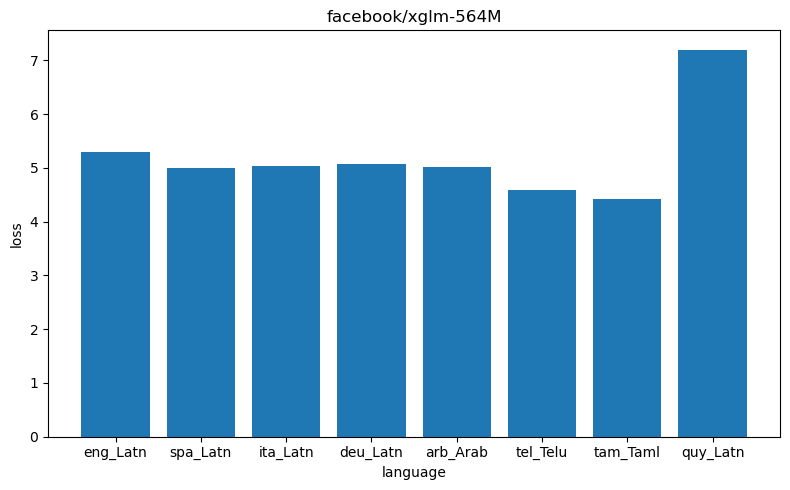

In [65]:
# create a figure
fig, axes = plt.subplots(figsize=(8, 5))

# create a bar plot for each langauge
# TODO: your code goes here
losses_avg = {}
for lang, loss_tensors in losses.items():
  # Move each loss tensor to CPU and convert to NumPy array, then calculate the average
  losses_avg[lang] = sum(loss.cpu().item() for loss in loss_tensors) / len(loss_tensors)

axes.bar(losses_avg.keys(), losses_avg.values())

# format plot
axes.set_xlabel("language") # x-axis label
axes.set_xticks(range(len(LANGUAGES))) # x-axis ticks
axes.set_xticklabels(losses.keys()) # x-axis tick labels
axes.set_ylabel("loss") # y-axis label
axes.set_title(MODEL_NAME); # title

plt.tight_layout()
plt.show()

## Comparing XGLM to GPT2

Your next task is to re-run the analysis above, but using `gpt2` as the pre-trained language model. For this exercise, focus on your native language, unless it's English or isn't covered by flores. In that case, pick another language that you can read well.

Compare the language modeling loss of XGLM and GPT2. What do you observe? Investigate the differences in tokenization for XGLM and GPT2. What do you observe? How can the good (or bad) performance of GPT2 be explained?

In [66]:
# TODO: your code goes here

MODEL_NAME = "gpt2" # specify model name

LANGUAGES = [
    "rus_Cyrl",
    "uzn_Latn"
]

language_flores_data = {}
for language in LANGUAGES:
  language_flores_data[language] = load_dataset_builder(DATA_SET_NAME, language, trust_remote_code=True)
  language_flores_data[language].download_and_prepare()

language_flores_data


# load a pre-trained tokenizer from the huggingface hub
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# gpt2 does not have a padding token, so we have to add it manually
if MODEL_NAME == "gpt2":
    tokenizer.add_special_tokens({'pad_token': tokenizer.unk_token})

# specify the tokenization function
def tokenize_function(example):
    return tokenizer(example['sentence'])
# TODO: your code goes here

tokenized_datasets = {lang: language_flores_data[lang].as_dataset().map(tokenize_function, batched=True) for lang in LANGUAGES}

for key, data in tokenized_datasets.items():
  tokenized_datasets[key] = tokenized_datasets[key].remove_columns(["id", "URL", "domain", "topic", "has_image", "has_hyperlink", "sentence"])
  tokenized_datasets[key].set_format("torch")

# construct a pytorch data loader for each dataset
from torch.utils.data import DataLoader
BATCH_SIZE = 2 # for testing purposes, we start with a batch size of 2. You can change this later.

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

flores_dataloaders = {}
# Iterate over languages
for language in LANGUAGES:
    flores_dataloaders[language] = {}  # Initialize a dictionary for each language
    # Iterate over data splits for the current language
    for split_name, dataset in tokenized_datasets[language].items():
      flores_dataloaders[language][split_name] = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=data_collator)
flores_dataloaders
# TODO: your code goes here

{'rus_Cyrl': {'dev': <torch.utils.data.dataloader.DataLoader at 0x7ffa08149540>,
  'devtest': <torch.utils.data.dataloader.DataLoader at 0x7ff9e8e930a0>},
 'uzn_Latn': {'dev': <torch.utils.data.dataloader.DataLoader at 0x7ff9e8ea72b0>,
  'devtest': <torch.utils.data.dataloader.DataLoader at 0x7ff9e8ea70a0>}}

In [67]:
tokenized_datasets['uzn_Latn']['dev'][0]

{'input_ids': tensor([   35,  1530,   272,  7012,   479, 35657,   520,   268,  3841, 26986,
           270,   316,  3191, 16653,    65,  7745,   313,   285,   461,  8658,
            72,   267,  2475,    75,  2743,   289, 23577,   323,  1373,  1501,
            72,   256,  6371,   283, 13827, 10662,   283,   397, 29008,   282,
           323,   267,  9435,  5516,   331,   648,    72,   256,  1077,    87,
           271,   410,  7434, 17053,  1312,   742,    72,  4951,  5362,   304,
             6, 14995, 10662,   688,    72,    25,  3971,   275, 14783,  1687,
          1084,   272, 35122, 39514,  9693,  1908,    72, 38324,    69,  3755,
          1489,     6,    75,  1030,  1302,   433, 28077,  4528, 20632,    75,
           446,   272,   277, 12192,   282, 37089,  1745,    64,   318, 18519,
           397,   442, 25011,   283,   680, 25682,  5116,  1489,     6,    75,
          1030,  5347,   488,  4914, 37284,  2611, 11594,    13]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 

In [68]:
# load pre-trained model from the huggingface hub
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
# put the model into evaluation mode
# TODO: your code goes here
model.eval()

losses = {lang: [] for lang in LANGUAGES} # store per-batch losses for each language

# Check if GPU is available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

for lang, loader in flores_dataloaders.items():
  for batch in loader['dev']:
    # for key, value in batch.items():
    #   print(key, value)
    with torch.no_grad():
      inputs = batch.to(device=device)
      labels = inputs["input_ids"]
      outputs = model(**inputs, labels = labels)
      loss = outputs.loss.cpu()
      losses[lang].append(loss)
      print(loss.item())
  print(f"Finished losses for {lang}")

# iterate over the datset for each language and compute the cross-entropy loss per batch
# TODO: your code goes here

cuda
2.1637468338012695
3.164803981781006
2.8353750705718994
3.659864664077759
3.117436408996582
4.554731369018555
3.1460185050964355
2.632448434829712
3.120335578918457
2.8556137084960938
2.2797865867614746
3.8732917308807373
2.777437686920166
3.7985424995422363
3.384066104888916
2.2896511554718018
3.4481041431427
2.4950931072235107
2.845871686935425
2.7286195755004883
2.6688790321350098
3.3449547290802
3.9533238410949707
3.2704696655273438
3.646172523498535
3.0290846824645996
2.8601083755493164
3.2098259925842285
2.961895704269409
3.140726089477539
3.0509543418884277
2.2515296936035156
3.2818682193756104
2.5888214111328125
3.1841914653778076
2.2971584796905518
3.0324037075042725
3.3038878440856934
2.9963526725769043
2.4989631175994873
2.6489598751068115
3.040764808654785
2.3030498027801514
2.9635937213897705
3.2247016429901123
2.3246524333953857
2.6477057933807373
3.6485419273376465
2.6024045944213867
2.6779613494873047
2.9912827014923096
2.937026023864746
2.8215832710266113
2.734534

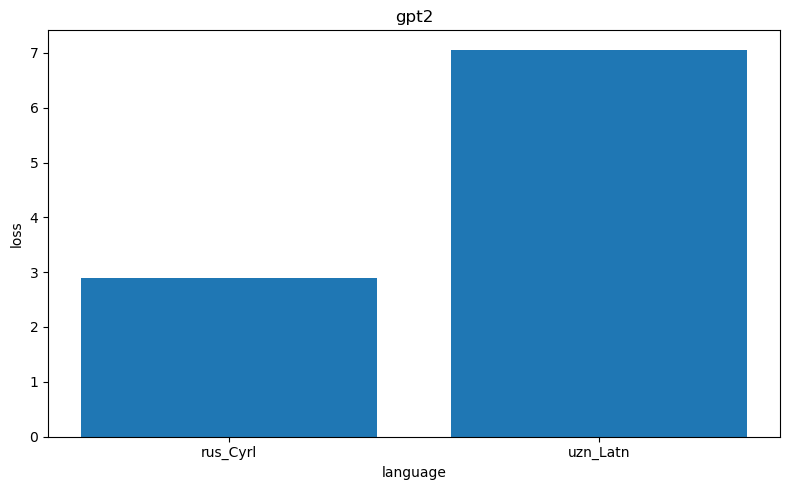

In [69]:
# create a figure
fig, axes = plt.subplots(figsize=(8, 5))

# create a bar plot for each langauge
# TODO: your code goes here
losses_avg = {}
for lang, loss_tensors in losses.items():
  # Move each loss tensor to CPU and convert to NumPy array, then calculate the average
  losses_avg[lang] = sum(loss.cpu().item() for loss in loss_tensors) / len(loss_tensors)

axes.bar(losses_avg.keys(), losses_avg.values())

# format plot
axes.set_xlabel("language") # x-axis label
axes.set_xticks(range(len(LANGUAGES))) # x-axis ticks
axes.set_xticklabels(losses.keys()) # x-axis tick labels
axes.set_ylabel("loss") # y-axis label
axes.set_title(MODEL_NAME) # title

plt.tight_layout()
plt.show()